<a href="https://colab.research.google.com/github/alecbidaran/VIT_From_Scratch_Pytorch/blob/main/VIT_From_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.1 MB/s eta 0:00

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 625.7 kB/s eta 0:00:00


In [160]:
import torch
from torchvision import transforms,datasets
from torch_snippets import *
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision.models as models
from collections import OrderedDict
from einops import rearrange

In [161]:
transform_t=transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5))])
train_dataset=datasets.MNIST(root="./data",download=True,train=True,transform=transform_t)
valid_dataset=datasets.MNIST(root="./data",download=True,train=False,transform=transform_t)

torch.Size([1, 32, 32])

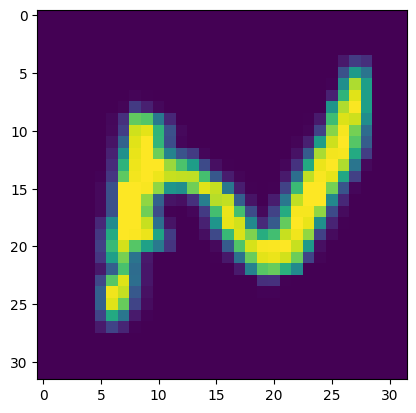

In [162]:
image,_=train_dataset[0]
plt.imshow(image.T)
image.shape


In [163]:
patch=torch.nn.Conv2d(3,768,kernel_size=16,stride=16)
patched=patch(image.unsqueeze(0))
patched.size()

RuntimeError: ignored

In [164]:
def scaled_dot_product_attention(key,query,value):
  scores=torch.bmm(query,key.transpose(1,2))/math.sqrt(key.size(-1))
  weights=torch.nn.functional.softmax(scores,dim=-1)
  attn_output=torch.bmm(weights,value)
  return attn_output

class AttentionHead(torch.nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = torch.nn.Linear(embed_dim, head_dim)
        self.k = torch.nn.Linear(embed_dim, head_dim)
        self.v = torch.nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model,nhead):
        super().__init__()
        embed_dim = d_model
        num_heads = nhead
        head_dim = embed_dim // num_heads
        self.heads = torch.nn.ModuleList([AttentionHead(embed_dim,head_dim) for _ in range(num_heads)])
        self.output_linear = torch.nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x
class FeedForward(torch.nn.Module):
    def __init__(self, d_model,hid_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(d_model,hid_dim)
        self.linear_2 = torch.nn.Linear(hid_dim,d_model)
        self.gelu = torch.nn.GELU()
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x
class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, d_model,nhead,hid_dim):
      super().__init__()
      self.layer_norm1=torch.nn.LayerNorm(d_model)
      self.layer_norm2=torch.nn.LayerNorm(d_model)
      self.attention=MultiHeadAttention(d_model,nhead)
      self.ff=FeedForward(d_model,hid_dim)
    def forward(self,x):
      l=self.layer_norm1(x)
      x1=self.attention(l)+x
      l2=self.layer_norm2(x1)
      x2=self.ff(l2)+l2
      return x2

In [165]:
import math
class PositionalEncoding(torch.nn.Module):
    def __init__(self,d_model,dropout):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        p=torch.arange(48).unsqueeze(1)
        wk=torch.exp(-torch.arange(0,d_model,2)*math.log(1000.0)/d_model)
        pe=torch.zeros(48,1,d_model)
        pe[:,0,0::2]=torch.sin(p*wk)
        pe[:,0,1::2]=torch.cos(p*wk)
        self.register_buffer('pe',pe)
    def forward(self,x):
      x=x+self.pe[:x.size(0)]
      return self.dropout(x)

In [166]:
class VIT(torch.nn.Module):
  def __init__(self,d_model,nhead,n_layer,hid_dim,dropout=0.1):
    super(VIT,self).__init__()
    self.patch=torch.nn.Conv2d(1,768,kernel_size=16,stride=16)
    encoder_layers=TransformerEncoderLayer(d_model,nhead,hid_dim)
    self.transformer_encoder=torch.nn.ModuleList([encoder_layers for _ in range(n_layer)])
    self.pos_emb=PositionalEncoding(d_model,dropout)
    self.output=torch.nn.Linear(768,10)
    self.nhead=nhead
    self.init_weights()
  def init_weights(self):
        initrange = 0.1
        self.output.bias.data.zero_()
        self.output.weight.data.uniform_(-initrange, initrange)

  def forward(self,x):
    x=self.patch(x).transpose(-2,-1)
    x=rearrange(x,'b c h w-> b (h w) c')
    x=rearrange(x,'b h c ->h b c')
    x=self.pos_emb(x)*math.sqrt(self.nhead)
    x=rearrange(x,'h b c->b h c')
    for layer in self.transformer_encoder:
      x=layer(x)
    return self.output(x[:,0,:])



In [168]:
model=VIT(d_model=768,nhead=4,n_layer=4,hid_dim=1024,dropout=0.1).to(device)
#model(torch.zeros(32,3,32,32).to(device)).size()

In [169]:
loss_fn=torch.nn.CrossEntropyLoss()
opti=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)


In [170]:
def train_step(inputs):
  x,y=inputs
  z=model(x.to(device))
  opti.zero_grad()
  loss=loss_fn(z,y.to(device))
  acc=(torch.argmax(z,dim=-1)==y.to(device)).float().mean()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
  opti.step()
  return loss,acc
@torch.no_grad()
def validation_step(input):
  model.eval()
  z=model(input)
  opti.zero_grad()
  loss=loss_fn(z,input)
  return loss


num_epoch=10
log=Report(num_epoch)

In [171]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)

In [172]:
for epoch in range(num_epoch):
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        loss,acc = train_step(data)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss,trn_acc=acc, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_acc: 0.675  trn_loss: 0.982  (57.07s - 513.66s remaining)
EPOCH: 2.000  trn_acc: 0.849  trn_loss: 0.487  (112.81s - 451.23s remaining)
EPOCH: 3.000  trn_acc: 0.879  trn_loss: 0.398  (167.52s - 390.89s remaining)
EPOCH: 4.000  trn_acc: 0.895  trn_loss: 0.349  (221.36s - 332.03s remaining)
EPOCH: 5.000  trn_acc: 0.908  trn_loss: 0.306  (275.09s - 275.09s remaining)
EPOCH: 6.000  trn_acc: 0.919  trn_loss: 0.269  (328.94s - 219.29s remaining)
EPOCH: 7.000  trn_acc: 0.928  trn_loss: 0.243  (382.54s - 163.94s remaining)
EPOCH: 8.000  trn_acc: 0.935  trn_loss: 0.214  (436.37s - 109.09s remaining)
EPOCH: 9.000  trn_acc: 0.942  trn_loss: 0.196  (490.22s - 54.47s remaining)
EPOCH: 10.000  trn_acc: 0.946  trn_loss: 0.177  (545.82s - 0.00s remaining)


In [173]:
image,label=next(iter(val_loader))
with torch.no_grad():
  pred=model(image.to(device))
  acc=(pred.argmax(1)==label.to(device)).float().mean()
print(acc)

tensor(0.9688, device='cuda:0')